In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from functools import partial
%matplotlib inline

In [2]:
from infmon.io import (get_contract_abi, get_event_interface, 
        get_current_block, get_contract_events)

In [9]:
uniswap_pools = {
    'ETH-DAI': '0x2a1530c4c41db0b0b2bb646cb5eb1a67b7158667',
    'ETH-USDC': '0x97dec872013f6b5fb443861090ad931542878126',
    'ETH-RPL': '0x3fb2f18065926ddb33e7571475c509541d15da0e',
    'ETH-BAT': '0x2e642b8d59b45a1d8c5aef716a84ff44ea665914'
}

In [59]:
token_pair = 'ETH-RPL'
token_address = uniswap_pools[token_pair]
token_abi = get_contract_abi(token_address)
token_interface = get_event_interface(token_abi)

In [12]:
trade_buy= get_contract_events(
    token_address,
    from_block=get_current_block() - 50000,
    topics=[token_interface['TokenPurchase']['topic']])

trade_sell= get_contract_events(
    token_address,
    from_block=get_current_block() - 50000,
    topics=[token_interface['EthPurchase']['topic']])

In [58]:
def create_trade_dataframe(token_pair, trade_buy, trade_sell):
    # Buy token for ETH
    token_buys = [token_interface['TokenPurchase']['decode'](t) for t in trade_buy]
    df_b = pd.DataFrame(token_buys
    ).rename(
        columns={'tokens_bought': 'tokens', 'eth_sold': 'eth'}
    ).assign(
        ETHTOK=lambda x: (x['tokens'] / x['eth']).astype(float),
        side='BUY', 
        tok=token_pair.replace('ETH-', '')
    )
    df_b['block_number'] = [int(t['blockNumber'], 16) for t in trade_buy]
    df_b['tokens'] = df_b['tokens'].astype(float) / 10**18
    df_b['eth'] = df_b['eth'].astype(float) / 10**18

    # Sell token for ETH
    token_sells = [token_interface['EthPurchase']['decode'](t) for t in trade_sell]
    df_s = pd.DataFrame(
        token_sells
    ).rename(
        columns={'tokens_sold': 'tokens', 'eth_bought': 'eth'}
    ).assign(
        ETHTOK=lambda x: (x['tokens'] / x['eth']).astype(float),
        side='SEL',
        tok=token_pair.replace('ETH-', '')
    )
    df_s['block_number'] = [int(t['blockNumber'], 16) for t in trade_sell]
    df_s['tokens'] = df_s['tokens'].astype(float) / 10**18
    df_s['eth'] = df_s['eth'].astype(float) / 10**18

    # Aggregate trades in each block by side 
    df = pd.pivot_table(
        pd.concat([df_b, df_s], axis=0, sort=False), 
        index=['block_number','side', 'tok'], 
        values=['eth',  'tokens', 'ETHTOK'], 
        aggfunc={
            'eth': 'sum',  'tokens': 'sum',  # Could use to calculate VWAP ETHTOK
            'ETHTOK': 'mean'  # This is mean ETHTOK over number of trades 
        }
    ).reset_index()
    return df

In [60]:
df = create_trade_dataframe(token_pair, trade_buy=trade_buy, trade_sell=trade_sell)

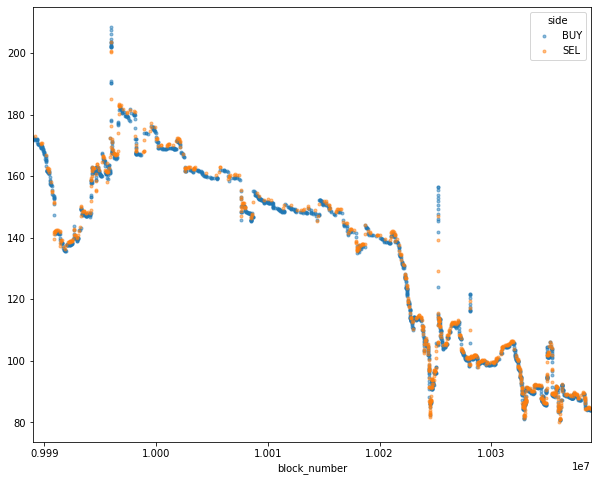

In [64]:
f = plt.figure(figsize=(10,8))
ax = f.gca()
_ = df.pivot_table(
    index='block_number', columns='side', values='ETHTOK'
).plot(y=['BUY', 'SEL'], linestyle='none', marker='.', ax=ax, alpha=0.5)
